In [1]:
# The Essentials
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np
import string
import spacy
import nltk
import re
import statistics

# Model Specific
from keras.layers import GlobalMaxPooling1D, Conv1D, MaxPooling1D, Flatten, LSTM
from keras.layers.core import Activation, Dropout, Dense
from keras.wrappers.scikit_learn import KerasClassifier
from keras.preprocessing.sequence import pad_sequences
from sklearn.model_selection import train_test_split
from keras.preprocessing.text import Tokenizer
from keras.layers.embeddings import Embedding
from sklearn.model_selection import KFold
from keras.models import Sequential

# NLTK
from nltk import LancasterStemmer, SnowballStemmer
from nltk.stem.wordnet import WordNetLemmatizer
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
from nltk.probability import FreqDist

# Numpy 
from numpy import array
from numpy import asarray
from numpy import zeros


sp = spacy.load('en_core_web_sm')

In [2]:
# Load Data
data = pd.read_csv("pubmed_data.csv")
data = data.drop(columns=['Unnamed: 0'])

lst_tables = []
years = []

# Compile how many unique years there are
for i in data['Year']:
    name = str(i)
    if i not in years: 
        lst_tables.append(['Data_'+str(i), i])
        years.append(i)
    
    
# Validation
print(len(set(data['Year'])))
print(len(lst_tables))

# see how many publications there were per year
data_by_year = data.groupby(['Year']).size().to_frame(name='Publication Count')
data_by_year['Year'] = data_by_year.index
data_by_year['Year'] = 'Data_' + data_by_year['Year'].astype(str)
data_by_year = data_by_year.reset_index(drop=True)
data_by_year

73
73


,Publication Count,Year
0,1,Data_1947.0
1,1,Data_1948.0
2,1,Data_1949.0
3,1,Data_1955.0
4,1,Data_1958.0
...,...,...
62,161,Data_2019.0
63,170,Data_2020.0
64,223,Data_2021.0
65,174,Data_2022.0


In [3]:
# Create a new dataframe with the abstracts and years
results = []
for entry in lst_tables:
    title = entry[0]
    year = entry[1]
    
    numb_pubs = 0
    abstract_list = []
    
    for idx, i in enumerate(data['Year']):
        if i == year:
            abstract = data['Abstract'][idx]
            abstract_list.append(abstract)
            numb_pubs += 1
    
    results.append([title, abstract_list]) 
    #title = pd.DataFrame(list(abstract_list), columns=[entry[0]])


In [4]:
# Clean up the abstracts with the NLTK Library. Additionally, perform NLP Frequency analysis
tokenized = results
all_names = []

results_dict = {}
results_arr = []

# create list of stopwords from NLTK 
en_stopwords = list(set(nltk.corpus.stopwords.words('english')))
en_stopwords += (['study', 'background', 'method', 'results', 'background', 'conclusions', 'objective', ''])

for idx, item in enumerate(results): 
    
    abstracts = " ".join(str(abstr) for idx, abstr in enumerate(results[idx][1]))
    
    tokens = nltk.word_tokenize(abstracts)
    
    # remove stopwords  
    filtered_sentence = [w for w in tokens if not w.lower() in en_stopwords]
    
    # remove punctuation from data
    scrubbed_sentence = [re.sub(r'[^\w\s]','',w).lower() for w in filtered_sentence]
    scrubbed_sentence = [x for x in scrubbed_sentence if x != ""]
    
    # Save the scrubbed sentences
    tokenized[idx][1] = scrubbed_sentence
 
    # Lemmatize the word
    WN = WordNetLemmatizer()
    WN_lemmatized = []
    for word in scrubbed_sentence: 
        WN_lemmatized.append(WN.lemmatize(word))

    # Find the frequency with which the words appear
    freq = nltk.FreqDist(WN_lemmatized)
    most_common = freq.most_common()
    frequency_dict = {}
    for p, pair in enumerate(most_common):
        frequency_dict[pair[0]] = pair[1]
        
    cur_df = pd.DataFrame.from_dict(frequency_dict, orient="index", columns=[tokenized[idx][0]])
    
    results_dict[tokenized[idx][0]] = frequency_dict
    results_arr.append([tokenized[idx][0], frequency_dict])
    

### Define Functions
Define a variety of generalizable functions that will aid in the analysis of the data to perform linguistic analysis on the type of research produced. 

In [202]:
def make_default_dataframe(results_dict):
    dates = []
    
    # extract all the dates there is data for
    for key, val in results_dict.items():
        dates.append(key)
    
    # create a dataframe with the dates 
    key_df = pd.DataFrame(dates, columns = ['Year'])
    key_df = pd.merge(data_by_year, key_df, on='Year', how='outer')

    # extract the numerical dates  
    key_df['Date'] = np.nan
    for j in range(len(key_df)):
        words = key_df['Year'][j].split('_')
        key_df['Date'][j] = words[1]

    key_df = key_df.set_index('Year')
    
    return key_df


def find_keywords(keywords, results_dict):
    
    key_df = make_default_dataframe(results_dict)
    
    # go through each of the keywords defined and save frequency distribution
    for temp in keywords: 
        key_df[temp] = 0
        for key, val in results_dict.items():
            if temp in val:
                key_df.loc[key, [temp]] = val[temp]
                
    key_df = rules(keywords, key_df)
    
    return key_df

def visualize_results(key_df):
    key_df.plot('Date')
    plt.show()
    
def rules(keywords, results):
    # this is a variation of the same word
    if 'abdomen' in keywords: 
        results['abdominal'] = results['abdominal'] + results['abdomen']
        results = results.drop('abdomen', axis=1)
    
    # this is a variation of the same word
    if 'vomit' in keywords: 
        results['vomiting'] = results['vomiting'] + results['vomit']
        results = results.drop('vomit', axis=1)
    
    # this is a variation of the same word
    if 'serping' in keywords: 
        results['serping'] = results['serping1'] + results['serping']
        results = results.drop('serping1', axis=1)
        
    # this is a variation of the same word
    if 'fxii' in keywords: 
        results['fxii'] = results['fxii'] + results['fxiihae'] + results['xii'] + results['fxiia'] + results['haefxiia']
        results = results.drop(['fxiihae', 'fxiia', 'xii', 'haefxiia'], axis=1)
        
    # this is a variation of the same word
    if 'c1inh' in keywords: 
        results['c1 inhibitor'] = results['c1inh'] + results['c1'] + results['c1inhibitor'] + results['c1esterase']
        results = results.drop(['c1inh', 'c1','c1inhibitor', 'c1esterase'], axis=1)
        
    # this is the same thing
    if 'erythema marginatum' in keywords:
        results['rash'] = results['rash'] + results['erythema marginatum']
        results = results.drop('erythema marginatum', axis=1)
    
    # this is the brand and generic name of a medicine    
    if 'lanadelumab' in keywords:
        results['lanadelumab'] = results['takzhyro'] + results['lanadelumab']
        results = results.drop('takzhyro', axis=1)
        
    # this is the brand and generic name of a medicine    
    if 'ruconest' in keywords:
        results['ruconest'] = results['c1 esterase inhibitor recombinant'] + results['ruconest']
        results = results.drop('c1 esterase inhibitor recombinant', axis=1)
        
    # this is the brand and generic name of a medicine    
    if 'berinert' in keywords:
        results['berinert'] = results['c1 esterase inhibitor human'] + results['berinert']
        results = results.drop('c1 esterase inhibitor human', axis=1)
    
    # this is the brand and generic name of a medicine    
    if 'haegarda' in keywords:
        results['haegarda'] = results['c1 esterase inhibitor subcutaneous'] + results['haegarda']
        results = results.drop('c1 esterase inhibitor subcutaneous', axis=1)
        
    # this is the brand and generic name of a medicine    
    if 'kalbitor' in keywords:
        results['ecallintide'] = results['kalbitor'] + results['ecallintide']
        results = results.drop('kalbitor', axis=1)
    
    # this is the brand and generic name of a medicine    
    if 'berotralstat' in keywords:
        results['orladeyo'] = results['berotralstat'] + results['orladeyo']
        results = results.drop('berotralstat', axis=1)
        
    # this is the brand and generic name of a medicine    
    if 'icatibant' in keywords:
        results['icatibant'] = results['icatibant'] + results['firazyr']
        results = results.drop('firazyr', axis=1)
        
    # this is the brand and generic name of a medicine    
    if 'danazol' in keywords:
        results['androgen'] = results['androgen'] + results['danazol']
        results = results.drop('danazol', axis=1)
        
    # this is a variation of a medicine name  
    if 'txa' in keywords:
        results['tranexamic acid'] = results['txa'] + results['tranexamic acid']
        results = results.drop('txa', axis=1)
        
    # this is a variation of the same keywords  
    if 'larynx' in keywords:
        results['larynx'] = results['larynx'] + results['laryngeal']+ results['airway']
        results = results.drop(['laryngeal', 'airway'], axis=1)
      
    # this is a variation of the same keywords  
    if 'extremities' in keywords:
        results['extremities'] = results['extremities'] + results['feet']+ results['hand']+ results['finger']
        results = results.drop(['hand','finger', 'feet'], axis=1)
      
    # this is a variation of the same keywords  
    if 'face' in keywords:
        results['face'] = results['face'] + results['lips']
        results = results.drop(['lips'], axis=1)
        
    # this is a variation of the same keywords  
    if 'dentist' in keywords:
        results['dental'] = results['dentist'] + results['dental']
        results = results.drop(['dentist'], axis=1)
        
    # this is a variation of the same keywords  
    if 'food' in keywords:
        results['food'] = results['food'] + results['alcohol']
        results = results.drop(['alcohol'], axis=1)
        
    # this is a variation of the same keywords  
    if 'menstruation' in keywords:
        results['menses'] = results['menstruation'] + results['menses']+ results['menstrual cycle']
        results = results.drop(['menstrual cycle', 'menstruation'], axis=1)
        
    # this is a variation of the same keywords  
    if 'abdominal' in keywords:
        results['abdominal'] = results['abdominal'] + results['gastrointestinal']
        results = results.drop(['gastrointestinal'], axis=1)
    
    return results

def groupby_year(og_df, years):
    df = og_df.copy()
    
    # add a dummy row at the top so it starts from the decade of the 1940s
    dummy = len(df.columns)*[0]
    date_col = df.columns.get_loc("Date")
    dummy[date_col] = 1940
    df.loc[-1] = dummy
    
    # convert the date column to datetime
    df['Date'] = pd.to_datetime(df['Date'], format='%Y')
    
    # select the columns by the decade/year interval specified
    result = df.set_index('Date').resample(years)['Publication Count'].sum()
    result = result.to_frame()
    
    column_names = list(df.columns.values)
    column_names.remove('Date')
    
    # Group by column
    for name in column_names:
        result[name] = df.set_index('Date').resample(years)[name].sum()

    return result

In [203]:
# Categories to Investigate
location = ['gastrointestinal', 'laryngeal', 'abdomen', 'abdominal', 'airway', 'skin', 'larynx', 'genital', 'lips', 'tongue', 'extremities', 'feet', 'hand', 'finger', 'face']
science = ['plasminogen', 'kinin', 'kallikrein', 'haefxiia', 'kininogen', 'c1inh', 'c1esterase', 'fxiihae', 'fxiia', 'c1', 'c4', 'fxii', 'c1inhibitor', 'prekallikrein', 'xii', 'kallikreinkinin', 'serping1', 'serping']
attack = ['prophylactic', 'prophylaxis', 'acute']
medicine = ['danazol', 'haegarda', 'c1 esterase inhibitor subcutaneous', 'androgen', 'berotralstat', 'c1 esterase inhibitor human', 'c1 esterase inhibitor recombinant', 'c1 esterase inhibitor human', 'ecallintide', 'kalbitor', 'icatibant', 'berinert', 'txa', 'firazyr', 'cinryze', 'ruconest', 'takzhyro', 'orladeyo', 'lanadelumab', 'tranexamic acid']
triggers = ['trigger', 'trauma', 'stress', 'infection', 'alcohol', 'cold', 'food', 'menstruation', 'menstrual cycle', 'menses', 'estrogen', 'dental', 'dentist']
prodromes = ['prodrome', 'prodromes']
symptoms = ['nausea', 'vomiting', 'pain', 'headache','cramp', 'diarrhea', 'edema', 'abdominal pain', 'vomit', 'dizziness', 'hypotension', 'fatigue', 'dyspnea', 'breathlessness', 'rash', 'erythema marginatum']


categories = [location, science, attack, medicine, triggers, prodromes, symptoms]
category_names = ['Location', 'Science', 'Attack', 'Medicine', 'Triggers', 'Prodromes', 'Symptoms']

In [204]:
# Find the total amounts of words from each category
total_by_category = make_default_dataframe(results_dict)

for c, i in enumerate(categories): 
    results = find_keywords(i, results_dict)
    results['Total '+ category_names[c]] = results.iloc[:, 2:].sum(axis=1)
    relevant = results.iloc[:, [1, -1]].copy()
    total_by_category = pd.merge(total_by_category, relevant, on='Date', how='outer')
    
    
total_by_category

<ipython-input-202-28e3d24b8082>:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  key_df['Date'][j] = words[1]


,Publication Count,Date,Total Location,Total Science,Total Attack,Total Medicine,Total Triggers,Total Prodromes,Total Symptoms
0,1.0,1947.0,0,0,0,0,0,0,0
1,1.0,1948.0,0,0,0,0,0,0,0
2,1.0,1949.0,0,0,0,0,0,0,0
3,1.0,1955.0,0,0,0,0,0,0,0
4,1.0,1958.0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...
63,170.0,2020.0,123,405,100,86,69,1,51
64,223.0,2021.0,165,479,181,164,104,13,120
65,174.0,2022.0,142,324,89,106,30,1,73
66,1.0,2023.0,0,0,0,0,2,0,0


In [221]:
#total_by_category
five_by_cat = []
five_by_cat.append(groupby_year(total_by_category, '5AS')) 

five_by_cat[0]

,Publication Count,Total Location,Total Science,Total Attack,Total Medicine,Total Triggers,Total Prodromes,Total Symptoms
Date,,,,,,,,
1940-01-01,0.0,0,0,0,0,0,0,0
1945-01-01,3.0,0,0,0,0,0,0,0
1950-01-01,0.0,0,0,0,0,0,0,0
1955-01-01,2.0,0,0,0,0,0,0,0
1960-01-01,8.0,0,0,0,0,0,0,0
1965-01-01,32.0,1,10,4,0,0,0,8
1970-01-01,89.0,2,63,1,0,1,0,11
1975-01-01,138.0,44,153,26,37,21,0,48
1980-01-01,148.0,49,292,20,52,15,0,61


In [205]:
'''
Indices & Category Names: 
[0] = Attack Location
[1] = Science
[2] = Attack Type
[3] = Treatment 
[4] = Trigger
[5] = Prodrome
[6] = Symptoms
'''

results_lst = []
five_results = []

for idx, category in enumerate(categories): 
    results_lst.append(find_keywords(category, results_dict))
    five_results.append(groupby_year(results_lst[-1], '5AS')) 

<ipython-input-202-28e3d24b8082>:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  key_df['Date'][j] = words[1]


The amount of publications and relevant keywords for Hereditary Angioedema keyword category: Science


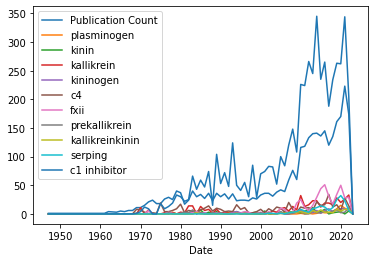

[5 year Interval] The amount of publications and relevant keywords for Hereditary Angioedema keyword category: Science


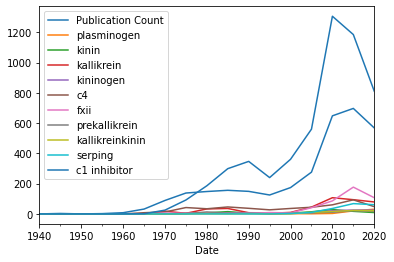

In [206]:
# Example Commands
index = 0

def get_results(results_lst, five_results,idx):
    print('The amount of publications and relevant keywords for Hereditary Angioedema keyword category:', category_names[idx])
    visualize_results(results_lst[idx])
    five_results[idx].plot()
    print('[5 year Interval] The amount of publications and relevant keywords for Hereditary Angioedema keyword category:', category_names[idx])


get_results(results_lst, five_results, 1)
#visualize_results(results_lst[index])
#print('The amount of publications and relevant keywords for Hereditary Angioedema keyword category:', category_names[index])

In [207]:
five_results[1]

,Publication Count,plasminogen,kinin,kallikrein,kininogen,c4,fxii,prekallikrein,kallikreinkinin,serping,c1 inhibitor
Date,,,,,,,,,,,
1940-01-01,0.0,0,0,0,0,0,0,0,0,0,0
1945-01-01,3.0,0,0,0,0,0,0,0,0,0,0
1950-01-01,0.0,0,0,0,0,0,0,0,0,0,0
1955-01-01,2.0,0,0,0,0,0,0,0,0,0,0
1960-01-01,8.0,0,0,0,0,0,0,0,0,0,0
1965-01-01,32.0,0,1,0,0,8,0,0,0,0,1
1970-01-01,89.0,0,0,18,1,13,6,0,0,0,25
1975-01-01,138.0,3,4,4,2,42,4,2,0,0,92
1980-01-01,148.0,2,7,33,7,34,8,13,2,0,186


In [208]:
'''
Indices & Category Names: 
[0] = Attack Location
[1] = Science
[2] = Attack Type
[3] = Treatment 
[4] = Trigger
[5] = Prodrome
[6] = Symptoms
'''

'\nIndices & Category Names: \n[0] = Attack Location\n[1] = Science\n[2] = Attack Type\n[3] = Treatment \n[4] = Trigger\n[5] = Prodrome\n[6] = Symptoms\n'

In [209]:
# Graphed
five_results[2]['Total Prophylactic'] = five_results[2]['prophylactic'] + five_results[2]['prophylactic']
five_results[2]

,Publication Count,prophylactic,prophylaxis,acute,Total Prophylactic
Date,,,,,
1940-01-01,0.0,0,0,0,0
1945-01-01,3.0,0,0,0,0
1950-01-01,0.0,0,0,0,0
1955-01-01,2.0,0,0,0,0
1960-01-01,8.0,0,0,0,0
1965-01-01,32.0,0,0,4,0
1970-01-01,89.0,0,0,1,0
1975-01-01,138.0,1,14,11,2
1980-01-01,148.0,5,4,11,10


In [210]:
# Graphed
five_results[3]

,Publication Count,haegarda,androgen,ecallintide,icatibant,berinert,cinryze,ruconest,orladeyo,lanadelumab,tranexamic acid
Date,,,,,,,,,,,
1940-01-01,0.0,0,0,0,0,0,0,0,0,0,0
1945-01-01,3.0,0,0,0,0,0,0,0,0,0,0
1950-01-01,0.0,0,0,0,0,0,0,0,0,0,0
1955-01-01,2.0,0,0,0,0,0,0,0,0,0,0
1960-01-01,8.0,0,0,0,0,0,0,0,0,0,0
1965-01-01,32.0,0,0,0,0,0,0,0,0,0,0
1970-01-01,89.0,0,0,0,0,0,0,0,0,0,0
1975-01-01,138.0,0,37,0,0,0,0,0,0,0,0
1980-01-01,148.0,0,52,0,0,0,0,0,0,0,0


In [211]:
# Graphed
five_results[4]

,Publication Count,trigger,trauma,stress,infection,cold,food,menses,hormones,estrogen,dental
Date,,,,,,,,,,,
1940-01-01,0.0,0,0,0,0,0,0,0,0,0,0
1945-01-01,3.0,0,0,0,0,0,0,0,0,0,0
1950-01-01,0.0,0,0,0,0,0,0,0,0,0,0
1955-01-01,2.0,0,0,0,0,0,0,0,0,0,0
1960-01-01,8.0,0,0,0,0,0,0,0,0,0,0
1965-01-01,32.0,0,0,0,0,0,0,0,0,0,0
1970-01-01,89.0,0,1,0,0,0,0,0,0,0,0
1975-01-01,138.0,0,7,0,1,0,3,1,0,0,9
1980-01-01,148.0,2,5,1,3,1,1,0,0,0,2


In [212]:
# Graphed
five_results[5]

,Publication Count,prodrome,prodromes
Date,,,
1940-01-01,0.0,0,0
1945-01-01,3.0,0,0
1950-01-01,0.0,0,0
1955-01-01,2.0,0,0
1960-01-01,8.0,0,0
1965-01-01,32.0,0,0
1970-01-01,89.0,0,0
1975-01-01,138.0,0,0
1980-01-01,148.0,0,0


In [213]:
# Graphed
five_results[6]

,Publication Count,nausea,vomiting,pain,headache,cramp,diarrhea,edema,abdominal pain,dizziness,hypotension,fatigue,dyspnea,breathlessness,rash
Date,,,,,,,,,,,,,,,
1940-01-01,0.0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1945-01-01,3.0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1950-01-01,0.0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1955-01-01,2.0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1960-01-01,8.0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1965-01-01,32.0,0,0,1,0,0,0,7,0,0,0,0,0,0,0
1970-01-01,89.0,0,0,2,0,1,0,8,0,0,0,0,0,0,0
1975-01-01,138.0,2,2,6,0,0,0,37,0,0,0,1,0,0,0
1980-01-01,148.0,1,2,3,2,0,0,51,0,1,0,0,0,0,1


In [186]:
# Graphed
five_results[0]

,Publication Count,abdominal,skin,larynx,genital,tongue,extremities,face
Date,,,,,,,,
1940-01-01,0.0,0,0,0,0,0,0,0
1945-01-01,3.0,0,0,0,0,0,0,0
1950-01-01,0.0,0,0,0,0,0,0,0
1955-01-01,2.0,0,0,0,0,0,0,0
1960-01-01,8.0,0,0,0,0,0,0,0
1965-01-01,32.0,0,1,0,0,0,0,0
1970-01-01,89.0,2,0,0,0,0,0,0
1975-01-01,138.0,14,3,24,0,0,0,3
1980-01-01,148.0,15,6,21,0,0,2,5
